In [1]:
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import requests
from urllib.parse import urlencode
from scipy import stats
from scipy.stats import levene
from scipy.stats import chi2_contingency

# A/B Test Results
*There are results of an A/B test in which two groups of users were offered different sets of promotional offers. It is known that ARPU in the test group is 5% higher than in the control group. At the same time, in the control group, 1928 players out of 202103 turned out to be paying, and in the test group – 1805 out of 202667.
\
Which set of offers can be considered the best? What metrics should be analyzed to make the right decision and how?*

In [5]:
# download data from yandex disk
def ya_disk_download(url):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    final_url = base_url + urlencode(dict(public_key=url)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
 
    download_response = requests.get(download_url) 
    df = pd.read_csv(download_url, sep=';')
    return df

In [3]:
ab_test_url = 'https://disk.yandex.ru/d/OSLVYBDSbxtH2w'

In [4]:
ab_test = ya_disk_download(ab_test_url)

In [6]:
ab_test.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [11]:
# approximately equal number of entries in each group
ab_test.groupby('testgroup').user_id.count()

testgroup
a    202103
b    202667
Name: user_id, dtype: int64

In [8]:
# no n/a data
ab_test.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [9]:
# the data format is correct
ab_test.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [10]:
# for each user there is a record with revenue, while most of the values are zero
ab_test.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


## ARPU
We can see from the descriptive statistics that most of the numbers lie near zero, there are outliers, which is why the standard deviation is also high (but higher for the first group), so there is need to check for differences in variances and the normality of the distribution

We can also see the ARPU indicator (average revenue), which is practically the same

In [12]:
ab_test.groupby('testgroup').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,202103.0,25.413720,920.768137,0.0,0.0,0.0,0.0,37433.0
b,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


In [13]:
a = ab_test.query('testgroup == "a"').revenue
b = ab_test.query('testgroup == "b"').revenue

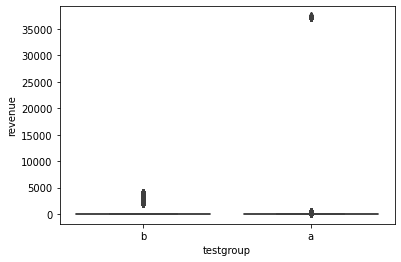

In [15]:
# distribution of payment
sns.boxplot(x='testgroup', y='revenue', data=ab_test)

#### On the charts, we can notice a certain oddity in the data - in group B, paying users are distributed up to 4000 units, while in group A, paying users are about 37000 units, which suggests that an error may have occurred when forming samples (one of the groups got a more paying category)

***
##### To begin with, let's check the subgroups for variance difference and normality

The variances between the groups do not differ significantly (Levene's test), but both groups are not distributed normally, as shown by the Shapiro-Wilk test. Despite the abnormality of the distributions, according to the Central Limit Theorem, the average values of the samples will be distributed normally with an increase in the number of observations (we have more than 200,000 observations in each group), so we could use t-test to compare the averages

It is also possible to calculate the Mann-Whitney criterion, provided that the number of duplicate values is not significant.

In [16]:
stat, p = levene(a, b)
p

0.5324948591043842

In [17]:
# we conduct the Shapiro-Wilk test on 100 random strings
stats.shapiro(ab_test.query('testgroup == "a"').revenue.sample(n=100))

ShapiroResult(statistic=0.07519251108169556, pvalue=3.3711737281791994e-22)

In [18]:
stats.shapiro(ab_test.query('testgroup == "b"').revenue.sample(n=100))

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


ShapiroResult(statistic=1.0, pvalue=1.0)

### Complete absence of significant differences in the Student's test

H0 - there is no difference in the mean values between groups A and B
\
H1 - there is a difference in the average values

In [19]:
stats.ttest_ind(a, b)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

### We see the number of repetitive values of more than 99% in each group, which limits the possibility of applying the U-criteria, and we cannot trust the result, but even so, it did not show significant differensec at level 5%

H0 - there is no difference in the distributions between groups A and B
\
H1 - difference in distributions present

In [20]:
(len(a) - len(a. drop_duplicates())) / len(a)

0.9986689955121894

In [21]:
(len(b) - len(b. drop_duplicates())) / len(b)

0.9940345492852808

In [22]:
ss.mannwhitneyu(a, b)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

##### ARPU summery
In both groups the majority of users are not paying while there are outliers of those who did make a purchase. Based on the results of the Student's t-test, it can be assumed that no significant differences (at the level of 5%) were found between the groups, but it is worth considering the factor that a mistake could have been made when forming into groups, since paying users at first glance differ greatly between groups

## ARPU

Conduct similar tests, but only among paying users

In [23]:
arppu = ab_test.query('revenue > 0')

In [24]:
a_arppu = arppu.query('testgroup == "a"').revenue
b_arppu = arppu.query('testgroup == "b"').revenue

We see that group **A** has a strong outlier, but the median differs in group **B** for the better

In [25]:
arppu.groupby('testgroup').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,1928.0,2663.998444,9049.039763,200.0,257.0,311.0,361.0,37433.0
b,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


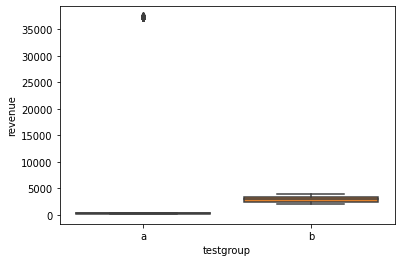

In [26]:
sns.boxplot(x='testgroup', y='revenue', data=arppu)

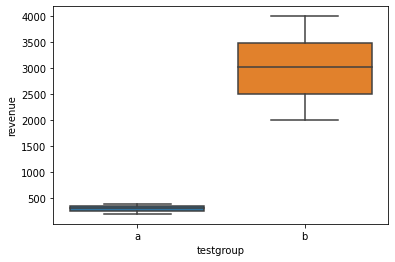

In [28]:
# without outliers
sns.boxplot(y='revenue', x='testgroup', data=arppu[arppu['revenue'] < 10000])

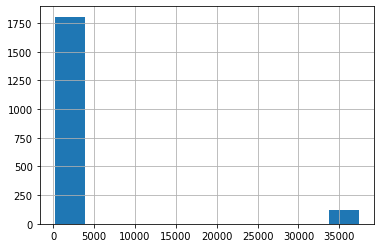

In [29]:
a_arppu.hist()

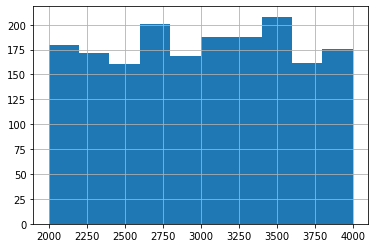

In [30]:
b_arppu.hist()

We see significant differences in the variances, the distribution is normal

In [31]:
stat, p = levene(a_arppu, b_arppu)
p

3.779689868667878e-19

In [32]:
stats.shapiro(a_arppu.sample(n=100))

ShapiroResult(statistic=0.2576979994773865, pvalue=3.428794824707572e-20)

In [33]:
stats.shapiro(b_arppu.sample(n=100))

ShapiroResult(statistic=0.9645978212356567, pvalue=0.008670209906995296)

***
We take Welch's **t-test**, which is more resistant to variance inequality, but we still get the absence of significant differences (only at the level of 10%)

In [34]:
stats.ttest_ind(a_arppu, b_arppu, equal_var=False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

In [35]:
ss.mannwhitneyu(a_arppu, b_arppu)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

In [39]:
# llook at the number of duplicate values among the paying group

In [37]:
(len(a_arppu) - len(a_arppu. drop_duplicates())) / len(a_arppu)

0.8609958506224067

In [38]:
(len(b_arppu) - len(b_arppu. drop_duplicates())) / len(b_arppu)

0.33074792243767315

In the first group, the repeated values are 86%, in the second - 33%, so here we could use the U-criterion with some assumptions
\
\
Among paying users, we already see a significant difference between groups where group **b** is significantly higher than group **a**

In [41]:
ss.mannwhitneyu(a_arppu, b_arppu)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

##### ARPPU summery
Welch's T-test still does not show us significant differences between groups, but it is present on the Mann-Whitney test and suggests that there is a difference in the distribution of groups. It can be assumed that the difference between the groups was confirmed either because Group B was actually more inclined to pay more, or this difference exists due to an error in data collection or the formation of the study design.

# CR
We use chi-squared to compare categorical data

In [42]:
ab_test['CR'] = ab_test.revenue.apply(lambda x: 'converted' if x > 0 else 'not_converted')

In [43]:
pd.crosstab(ab_test.CR, ab_test.testgroup)

testgroup,a,b
CR,,
converted,1928,1805
not_converted,200175,200862


In [44]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(ab_test.CR, ab_test.testgroup))

In [45]:
stat, p

(4.374729521260405, 0.03647561892312613)

##### CR summery
The achieved distributions between the payability groups differ from those that would be with equal conversions